In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm

uplifted = pd.read_csv('../data/peaks.min_peak_score_0.6.thresh_0.5.csv', index_col=0)
# uplifted.drop('Unnamed: 0', inplace=True, axis=1)
uplifted.tail()

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,chrom,start,end,peak_pos,score
1037952,chr22,51240000,51240029,51240015,0.88
1037953,chr22,51240123,51240147,51240135,0.81
1037954,chr22,51240936,51240962,51240949,0.81
1037955,chr22,51242531,51242561,51242546,0.76
1037956,chr22,51243098,51243127,51243116,0.83


In [2]:
df = pd.read_csv('../data/chr1.S15-30.filtered.csv', index_col=0, dtype='int')
df.tail()

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,start,end,len_stem,len_loop
10941414,249239500,249239542,18,10
10941416,249239505,249239540,15,8
10941418,249239530,249239566,15,9
10941422,249239532,249239564,16,4
10941426,249239644,249239681,17,7


In [18]:
ss10bp = pd.read_csv('../data/sec_struct_0-10bp_to_nucleosome.csv', dtype='int')

def add_bp_according2_start_end(neg_example):
    """
adds nucleotides string according to start-end columns
    :param neg_example: DataFrame with start-end columns
    """
    from Bio import SeqIO
    first_record = str(next(SeqIO.parse("/home/shared/hg19/chr1.fna", "fasta")).seq)

    temp = pd.DataFrame(np.ndarray((neg_example.shape[0], 4)),
                        columns=["struct", "before", "after", 'half_struct'], dtype='str')
    for idx, row in neg_example.iterrows():
        temp.loc[idx][0] = first_record[row['start']:row['end']]
        temp.loc[idx][1] = first_record[row['start'] - 20:row['start']]
        temp.loc[idx][2] = first_record[row['end']:row['end']    + 20]
        temp.loc[idx][3] = first_record[row['start']:row['start'] + (row['end'] - row['start'])//2]

    return pd.concat([neg_example, temp], axis=1)

ss10bp = add_bp_according2_start_end(ss10bp)
ss10bp.head()

,start,end,len_stem,len_loop,center,struct,before,after,half_struct
0,1354102,1354142,17,8,1354122,CAGGCAGGCGCAGGCCTGGTTTCGGGCCTAGCGCCAGGCT,TTCAACTACTGGGTTTAGGC,GCCTGCCTGTCTTTGGTTTT,CAGGCAGGCGCAGGCCTGGT
1,3773878,3773916,16,7,3773897,GGGGCCACGGCACCTGGGCACACCAGGTGGCGTCGCGC,CTCAGGGTTGTGTAGTTTCC,CTTTGCTTTCCTGAGCCTTC,GGGGCCACGGCACCTGGGC
2,4215013,4215053,17,9,4215033,AGGCTGGAGTGCAGTGGCACAGTCACAACTCACTGCAGCC,TTTAACAGGCTCCATTGCCC,TTGACCACCTGGGCTTAAGC,AGGCTGGAGTGCAGTGGCAC
3,9648647,9648689,17,10,9648668,GCCCTCCCCGCGCCGCCTTCCACCTCCGGCCGCGCGGGGGCG,CCTACAGGGCTCCGTGCCCC,CTCCCCGGCCGGCTCTGTCG,GCCCTCCCCGCGCCGCCTTCC
4,9898650,9898683,17,2,9898666,GATTGCAGTGAGCGGAGATCGCGCCACTGCACT,GCGTGAACCTGGGGGGCAGA,CCAGCCTGGGTGACAGAGCG,GATTGCAGTGAGCGGA


In [4]:
neg_example = df.sample(15000).reset_index()

from Bio import SeqIO
first_record = str(next(SeqIO.parse("/home/shared/hg19/chr1.fna", "fasta")).seq)

temp = pd.DataFrame(np.ndarray((neg_example.shape[0], 4)), columns=["struct", "before", "after", 'half_struct'], dtype='str')
for idx, row in neg_example.iterrows():
    temp.loc[idx][0] = first_record[row['start']:row['end']]
    temp.loc[idx][1] = first_record[row['start'] - 20:row['start']]
    temp.loc[idx][2] = first_record[row['end']:row['end']    + 20] 
    temp.loc[idx][3] = first_record[row['start']:row['start'] + (row['end'] - row['start'])//2]

neg_example = pd.concat([neg_example, temp], axis=1)
neg_example.head(2)

,index,start,end,len_stem,len_loop,struct,before,after,half_struct
0,6066963,196143342,196143377,17,6,TTTTTAAGGCTCACTACACACAGTACTCTATGAAA,AGATCAGGGAGTCATAAGGA,AAGATTGTCAATGCTATGGA,TTTTTAAGGCTCACTAC
1,1577133,149980359,149980393,15,7,GAAAGATTAAACAAATAAAGCTTTGGGAAATTTT,TTTAAATAGGGGTCTCAAAA,CCAAGTTGTTGGCAACATAA,GAAAGATTAAACAAATA


In [19]:
neg_example['value'] = 0
ss10bp['value'] = 1
concated = pd.concat([neg_example, ss10bp])
concated.head(2)

,after,before,center,end,half_struct,index,len_loop,len_stem,start,struct,value
0,AAGATTGTCAATGCTATGGA,AGATCAGGGAGTCATAAGGA,NaN,196143377,TTTTTAAGGCTCACTAC,6066963.0,6,17,196143342,TTTTTAAGGCTCACTACACACAGTACTCTATGAAA,0
1,CCAAGTTGTTGGCAACATAA,TTTAAATAGGGGTCTCAAAA,NaN,149980393,GAAAGATTAAACAAATA,1577133.0,7,15,149980359,GAAAGATTAAACAAATAAAGCTTTGGGAAATTTT,0


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import re
from MulticoreTSNE import MulticoreTSNE as TSNE  # https://github.com/DmitryUlyanov/Multicore-TSNE
concated.isnull().sum()

after              0
before             0
center         15000
end                0
half_struct        0
index           3458
len_loop           0
len_stem           0
start              0
struct             0
value              0
dtype: int64

In [28]:
diprodb = pd.read_csv('../data/dprops.csv', index_col=0)

features = []
for struct in tqdm(concated.loc[:, concated.columns != 'value']['half_struct']):
    strl = re.findall('..', struct)
    temp = []
    for dyad in strl:
        temp.append(diprodb[diprodb['PropertyName'] == dyad].values.tolist()[0])
    features.append(pd.DataFrame(temp, columns=diprodb.columns).sum())
features = pd.DataFrame(features)


# tsne = TSNE(n_jobs=8)
# transformed = tsne.fit_transform(features.loc[:, features.columns != 'PropertyName'])

# vis_x = transformed[:, 0]
# vis_y = transformed[:, 1]



# plt.scatter(vis_x, vis_y, c=concated['value'].map({0: 'blue', 1: 'orange'}))
# # plt.clim(-0.5, 9.5)
# plt.show()

HBox(children=(IntProgress(value=0, max=18458), HTML(value='')))

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    features.drop('PropertyName', axis=1).values, concated['value'].values,
    test_size=0.2)

import telepyth # push notif in telegram

%telepyth -t 1260389131217015787

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
verbose = 1
plot = 1
params = {
#     "max_bin": 1024,
    "learning_rate": 0.01,
    "boosting_type": "goss",
    "objective": "binary",
    'num_iterations':10000,
    "metric": "auc",
    "num_leaves": 10000,
    "verbose": 1,
#     "min_data": 100,
#     "boost_from_average": True
}

d_train = lgb.Dataset(x_train, y_train)
# d_valid = lgb.Dataset(X_test, label=y_test)
model = lgb.train(params, d_train)
# model.save_model('regressin')
# model = lgb.Booster(model_file='regressin')

y_pred = model.predict(x_test)
print(roc_auc_score(y_test, y_pred))

df_fi = pd.DataFrame(features.columns[1:], columns=['feature'])
df_fi['importance'] = list(model.feature_importance('gain'))
df_fi.sort_values('importance', ascending=False, inplace=True)
# print(df_fi)
if plot:
    plt.figure()
    df_fi.head(10).plot(kind='barh', x='feature', y='importance')
    plt.title('Roc_auc is {}'.format(roc_auc_score(y_test, y_pred)))
    plt.xlabel('relative importance')
    plt.show()

%telepyth 'lgb! \n'

In [42]:
all_quad_coords = pd.read_csv('/home/konovalovdmitry/results/all_quad_coords.tsv', sep='\t', header=None)
all_quad_coords = all_quad_coords[all_quad_coords[0] == 'chr1']
cols = ['chr', 'start', 'end']
all_quad_coords.columns = cols
df = all_quad_coords.copy()
df.head()

,chr,start,end
159631,chr1,10003,10024
159632,chr1,10027,10048
159633,chr1,10051,10072
159634,chr1,10075,10096
159635,chr1,10099,10119


In [146]:
quadparser = pd.read_csv('/home/konovalovdmitry/results/fna/chr1.qp', sep='\t').reset_index()
# pd.DataFrame(quadparser['level_0'].str.split('-').values.tolist(), columns=['start', 'end'])
quadparser.drop(quadparser.tail(1).index, inplace=True)
df_str = pd.DataFrame(quadparser['level_0'].str.split('-').values.tolist(), columns=['start', 'end'])
df_str.drop(df_str[df_str['start'] == 'Found 10206:5547:5196 overlapping:sequences:lines'].index, inplace=True)
df_str = df_str.astype(int)
df = pd.concat([quadparser['chr1'], df_str], axis=1)


HBox(children=(IntProgress(value=0, max=1037767), HTML(value='')))

Text(0.5,0,'Centered position')

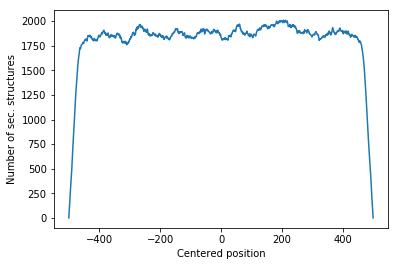

In [147]:
cumsum_arr = np.zeros(1000)

for peak_pos in tqdm(pd.to_numeric(uplifted.peak_pos)):
    temp_df = df[(df['start'] > peak_pos - 500) & (df['end'] < peak_pos + 500)]
    for ind, row in temp_df.iterrows():
        for i in range(int(row['start']) - peak_pos + 500, int(row['end']) - peak_pos + 500):
            cumsum_arr[i] += 1
# cumsum_arr

x = np.arange(-500, 500)
plt.plot(x, cumsum_arr)
plt.ylabel('Number of sec. structures')
plt.xlabel('Centered position')

In [161]:
def make_10bp(df, uplifted):
    """
Выделить все структуры, у которых основание ножки находятся на расстоянии от 0 до 10 нуклеотидов от границы нуклеосомы.
    :param df: sec. struct. df
    :param uplifted: nucleosome df
    """
    arr_4_rows = []
    for start_upl in tqdm(pd.to_numeric(uplifted.start)):
        temp_df = df[(df['end'] > start_upl - 10) & (df['end'] < start_upl)]
        if not temp_df.empty:
            for ind, row in temp_df.iterrows():
                arr_4_rows.append(row)
    ss10bp = pd.DataFrame(arr_4_rows)
#     ss10bp.to_csv('sec_struct_0-10bp_to_nucleosome.csv', index=False)
    return ss10bp

quad10bp = make_10bp(df, uplifted)

HBox(children=(IntProgress(value=0, max=1037767), HTML(value='')))

In [162]:
print(quad10bp.shape[0] / all_quad_coords.shape[0] * 100)

1.4124860327192506


In [170]:
quad10bp[['start', 'end']] = quad10bp[['start', 'end']].astype(int)
quad10bp = quad10bp.reset_index(drop=True)

5% out of all quadruplexes are near nucleosomes

In [150]:

def make_go_terms(ss10bp, suffix='quad'):
    """
makes go_terms.csv for pasting to http://revigo.irb.hr/ and getting genes and their types
also makes relevant_goa_names.csv for names of this genes
    :return:
    """
    ptt = pd.read_csv('../data/ptt_hg19.txt', delimiter='\t')
    ptt1 = ptt[ptt['chrom'] == 'chr1']

    def make_10bp_pr(df, uplifted):
        arr_4_rows = []
        for start_upl in tqdm(pd.to_numeric(uplifted.end)):
            temp_df = df[(df['txStart'] - 1000 < start_upl) & (df['txEnd'] > start_upl) & (df.strand == '+')]
            if not temp_df.empty:
                for ind, row in temp_df.iterrows():
                    arr_4_rows.append(row)
        return pd.DataFrame(arr_4_rows)

    relevant_ptt = make_10bp_pr(ptt1, ss10bp)

    goa = pd.read_csv('../data/goa_human.gaf', delimiter='\t', header=None)

    relevant_goa = goa[goa[1].isin(relevant_ptt.proteinID)].drop_duplicates(1)
    relevant_goa[9].to_csv('../data/relevant_goa_names_{}.csv'.format(suffix))
    relevant_goa[4].to_csv('../data/go_terms_{}.csv'.format(suffix), index=False)

make_go_terms(quad10bp)

HBox(children=(IntProgress(value=0, max=493), HTML(value='')))

In [172]:
def add_bp_according2_start_end(neg_example):
    """
adds nucleotides string according to start-end columns
    :param neg_example: DataFrame with start-end columns
    """
    from Bio import SeqIO
    first_record = str(next(SeqIO.parse("/home/shared/hg19/chr1.fna", "fasta")).seq)

    temp = pd.DataFrame(np.ndarray((neg_example.shape[0], 4)),
                        columns=["struct", "before", "after", 'half_struct'], dtype='str')
    for idx, row in neg_example.iterrows():
        temp.loc[idx][0] = first_record[row['start']:row['end']]
        temp.loc[idx][1] = first_record[row['start'] - 20:row['start']]
        temp.loc[idx][2] = first_record[row['end']:row['end']    + 20]
        temp.loc[idx][3] = first_record[row['start']:row['start'] + (row['end'] - row['start'])//2]

    return pd.concat([neg_example, temp], axis=1)

quad10with_bps = add_bp_according2_start_end(quad10bp)


In [183]:
neg_example = all_quad_coords.sample(5000).reset_index(drop=True)
neg_example = add_bp_according2_start_end(neg_example)
neg_example['value'] = 0
quad10with_bps['value'] = 1
quad10with_bps.drop('chr1', inplace=True, axis=1)
neg_example.drop('chr', inplace=True, axis=1)
concated = pd.concat([neg_example, quad10with_bps])
concated.head(2)

,start,end,struct,before,after,half_struct,value
0,46447073,46447097,GGGCAGGGGGCTAGGGAATGGGGG,TTTTTTAAGGATAGTTTGGT,AATGTTGAGTAGTTGAGTCA,GGGCAGGGGGCT,0
1,11837852,11837885,CCCCACAACCCCCAGGCCCTCCCTCTCCAGCCC,GGGCACTGCTCACATGCCTG,ATCCTCTGGCCTTTGGACTT,CCCCACAACCCCCAGG,0


In [184]:
concated.tail()

,start,end,struct,before,after,half_struct,value
488,38300074,38300102,GGGTGGGGGCGGCGGGGGTGGGGGAAGG,CTTTGGGAGGCTGAGACAGA,GAAAGACTGCTTGGACCTTA,GGGTGGGGGCGGCG,1
489,38410448,38410479,GGGGAGCGGGAGGTGGGGCGGGGTAGGGGGG,TTTTTTGTAGAGATGGAGCC,GCGGTCTCGCTATGTTGCCC,GGGGAGCGGGAGGTG,1
490,41346049,41346078,GGGGTGGGGAGGCTGGGGGTGGGGTGGGG,GTCTGAACAAAAGGAGCAGT,GATGTTAGTGATGATGAGGG,GGGGTGGGGAGGCT,1
491,41922974,41923031,GGGTTGGATGGGGAGGCTCAGGGGGCCCAGAGGGTTCCGGGTGCCC...,GCCCATCCAGGCAGGTGTCA,GCATCTTGCAGTAGGAGCCC,GGGTTGGATGGGGAGGCTCAGGGGGCCC,1
492,45023093,45023115,GGGAGGGAGGGAGAGAGGGAGG,AGAGAGGAAGGAAGGAAGGA,GAAAGAAGGAAGGAAGGAAG,GGGAGGGAGGG,1


In [185]:
def calc_feats(concated, position='half_struct'):
    """
calculate features from diprodb
    :param position: struct, before, after or half_struct
    :param concated: df with bp as after add_bp_according2_start_end
    """
    diprodb = pd.read_csv('../data/dprops.csv', index_col=0)
    import re
    features = []
    for struct in tqdm(concated.loc[:, concated.columns != 'value'][position]):
        strl = re.findall('..', struct)
        temp = []
        for dyad in strl:
            temp.append(diprodb[diprodb['PropertyName'] == dyad].values.tolist()[0])
        features.append(pd.DataFrame(temp, columns=diprodb.columns).sum())
    return pd.DataFrame(features)
feats = calc_feats(concated)

HBox(children=(IntProgress(value=0, max=5493), HTML(value='')))

In [186]:
feats.head(2).append(feats.tail(2))

,PropertyName,Twist,Stacking_energy,Rise,Bend,Tip,Inclination,Major_Groove_Width,Major_Groove_Depth,Major_Groove_Size,...,Roll.3,Tilt.3,Twist.5,Roll.4,Twist.6,Flexibility_slide,Flexibility_shift,Enthalpy.1,Entropy.1,Free_energy.8
0,GGGCAGGGGGCT,207.68,-64.7,23.31,14.16,6.43,3.33,88.04,51.94,24.60,...,2.2,-1.8,201.4,4.8,215.3,41.58,36.47,-49.4,-126.1,-10.32
1,CCCCACAACCCCCAGG,286.23,-83.6,30.20,20.42,5.67,-3.56,115.55,69.45,31.84,...,5.4,-1.0,269.3,14.7,283.1,61.44,47.24,-64.5,-165.9,-13.09
5491,GGGTTGGATGGGGAGGCTCAGGGGGCCC,518.38,-153.2,51.96,37.06,7.44,3.50,201.97,121.27,54.28,...,27.0,-1.9,471.5,38.7,495.3,90.26,78.46,-115.9,-299.7,-22.95
5492,GGGAGGGAGG,187.50,-51.3,19.18,11.50,4.83,2.67,74.33,42.87,18.46,...,7.9,-5.2,168.5,14.2,183.3,42.64,27.41,-40.4,-104.1,-8.12


In [187]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import re
from MulticoreTSNE import MulticoreTSNE as TSNE  # https://github.com/DmitryUlyanov/Multicore-TSNE


def plot_tsne(ss10bp, position='struct'):
    """
form  physical features dataframe and use t-sne on it
https://lvdmaaten.github.io/tsne/
    :param position: before, after or struct for position relative to structure
    :param ss10bp: see preprocessing.py, sec. structs within 10bp from nucleosome
    :return: plt for plt.show()
    """
    diprodb = pd.read_csv('../data/dprops.csv', index_col=0)

    features = []
    for struct in tqdm(ss10bp[position]):
        strl = re.findall('..', struct)
        temp = []
        for dyad in strl:
            temp.append(diprodb[diprodb['PropertyName'] == dyad].values.tolist()[0])
        features.append(pd.DataFrame(temp, columns=diprodb.columns).sum())
    features = pd.DataFrame(features)


    tsne = TSNE(n_jobs=8)
    transformed = tsne.fit_transform(features.loc[:, features.columns != 'PropertyName'])

    vis_x = transformed[:, 0]
    vis_y = transformed[:, 1]

    plt.scatter(vis_x, vis_y, cmap=plt.cm.get_cmap("jet", 10))
    plt.clim(-0.5, 9.5)
    return plt
    # plt.show()
    # or we can do this and label relevant vs random
    # diprodb = pd.read_csv('../data/dprops.csv', index_col=0)
    #
    # features = []
    # for struct in tqdm(concated.loc[:, concated.columns != 'value']['before']):
    #     strl = re.findall('..', struct)
    #     temp = []
    #     for dyad in strl:
    #         temp.append(diprodb[diprodb['PropertyName'] == dyad].values.tolist()[0])
    #     features.append(pd.DataFrame(temp, columns=diprodb.columns).sum())
    # features = pd.DataFrame(features)
    #
    # tsne = TSNE(n_jobs=8)
    # transformed = tsne.fit_transform(features.loc[:, features.columns != 'PropertyName'])
    #
    # vis_x = transformed[:, 0]
    # vis_y = transformed[:, 1]
    #
    # plt.scatter(vis_x, vis_y, c=concated['value'].map({0: 'blue', 1: 'orange'}))
    # # plt.clim(-0.5, 9.5)
    # plt.show()



HBox(children=(IntProgress(value=0, max=493), HTML(value='')))

<module 'matplotlib.pyplot' from '/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/matplotlib/pyplot.py'>

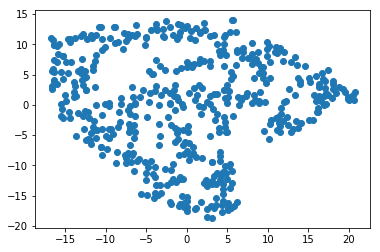

In [188]:
plot_tsne(quad10with_bps)

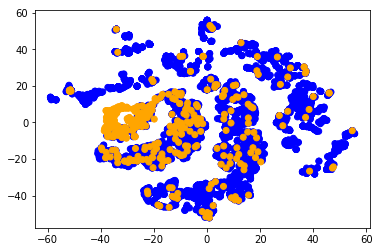

In [189]:

tsne = TSNE(n_jobs=8)
transformed = tsne.fit_transform(feats.loc[:, feats.columns != 'PropertyName'])

vis_x = transformed[:, 0]
vis_y = transformed[:, 1]

plt.scatter(vis_x, vis_y, c=concated['value'].map({0: 'blue', 1: 'orange'}))
# plt.clim(-0.5, 9.5)
plt.show()

In [190]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    feats.drop('PropertyName', axis=1).values, concated['value'].values,
    test_size=0.3)
%load_ext wurlitzer  
import telepyth # push notif in telegram

%telepyth -t 1260389131217015787

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


Use token 1260389131217015787.


In [191]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
np.random.seed(42)
verbose = 1
plot = 1
params = {
#     "max_bin": 1024,
#     "learning_rate": 0.01,
    "boosting_type": "goss",
    "objective": "binary",
#     'num_iterations':10000,
    "metric": "auc",
#     "num_leaves": 10000,
    "verbose": 1,
#     "min_data": 100,
#     "boost_from_average": True,
    'early_stopping_round': 50
}

d_train = lgb.Dataset(x_train, y_train)
d_valid = lgb.Dataset(x_test, label=y_test)
model = lgb.train(params, d_train, valid_sets=d_valid)
# model.save_model('regressin')
# model = lgb.Booster(model_file='regressin')

y_pred = model.predict(x_test)
print(roc_auc_score(y_test, y_pred))

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.774457[LightGBM] [Info] Number of positive: 338, number of negative: 3507
[LightGBM] [Info] Total Bins 26398
[LightGBM] [Info] Number of data: 3845, number of used features: 125
[LightGBM] [Info] using GOSS

Training until validation scores don't improve for 50 rounds.
[2]	valid_0's auc: 0.78084
[3]	valid_0's auc: 0.78744
[4]	valid_0's auc: 0.787961
[5]	valid_0's auc: 0.791358
[6]	valid_0's auc: 0.796098
[7]	valid_0's auc: 0.803589
[8]	valid_0's auc: 0.800791
[9]	valid_0's auc: 0.795586
[10]	valid_0's auc: 0.78991
[11]	valid_0's auc: 0.792611
[12]	valid_0's auc: 0.802362
[13]	valid_0's auc: 0.804775
[14]	valid_0's auc: 0.804889
[15]	valid_0's auc: 0.80014
[16]	valid_0's auc: 0.807528
[17]	valid_0's auc: 0.807067
[18]	valid_0's auc: 0.806285
[19]	valid_0's auc: 0.807683
[20]	valid_0's auc: 0.809606
[21]	valid_0's auc: 0.807121
[22]	valid_0's auc: 0.809038
[23]	valid_0's auc: 0.808496
[24]	valid_0's auc: 0.80772
[25]	valid_0's auc: 0.801942
[26]	valid_0's auc: 0.8010

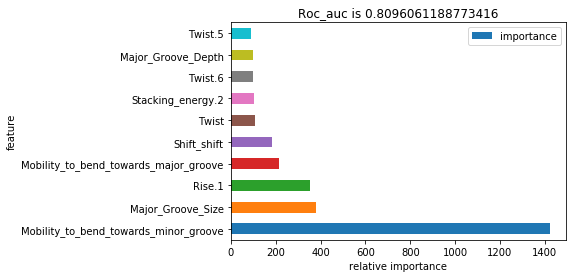

Error in callback <function sys_pipes_forever at 0x7fd9faa2b378> (for pre_execute):


RuntimeError: generator didn't yield

'lgb! \n'

In [192]:
df_fi = pd.DataFrame(features.columns[1:], columns=['feature'])
df_fi['importance'] = list(model.feature_importance('gain'))
df_fi.sort_values('importance', ascending=False, inplace=True)
# print(df_fi)
if plot:
    plt.figure()
    df_fi.head(10).plot(kind='barh', x='feature', y='importance')
    plt.title('Roc_auc is {}'.format(roc_auc_score(y_test, y_pred)))
    plt.xlabel('relative importance')
    plt.show()

%telepyth 'lgb! \n'